# 25 VGG - 使用块的网络

相较于LeNet（引入卷积），AlexNet（在LeNet上增加层数+一些优化），VGG引入块的概念，对前两者进行了封装。将一些卷积层+池化层的组合打包成一个块，然后将多个块打包成一个网络。

## 深 vs 宽？

使用 5 * 5 卷积核，单层的参数量会变大，总参数量相同时层数较浅。

使用 3 * 3 卷积核，单层的参数量会变小，总参数量相同时层数较深。

最终发现深但窄效果更好

## VGG 块

使用 3 * 3 卷积核（padding=1以保证每次卷积后图像大小不变）和 2 * 2 最大池化层（stride=2）

## VGG 架构

使用多个VGG块，最后接全连接层。

不同次数的重复块得到不同的架构。

## LeNet vs AlexNet vs VGG

+ LeNet

2 卷积 + 池化

2 全连接层

+ AlexNet

更大更深

ReLU, Dropout, 数据增强

+ VGG

重复的VGG块，更大更深的AlexNet

## 代码实现

### VGG块

卷积核大小3*3，填充1，步幅1，以保证前后图片大小不变

每个卷积层后面带一个ReLU激活函数

每个VGG块最后是一个最大池化层，池化核大小2*2，步幅2，以保证图片尺寸减半

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### VGG网络

conv_arch: 一个列表，指定每个VGG层的卷积层个数和输出通道数

我们想要构建的VGG网络的参数如下：

In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

构建一个样本，通过其在VGG网络中正向传播的过程，打印每一层的输出的形状

In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 训练模型

In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.171, train acc 0.936, test acc 0.918
67.1 examples/sec on cpu


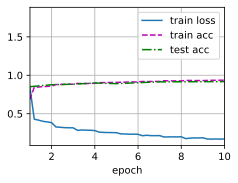

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())